In [1]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.attribute import YEAR_ATTR, AGE_ATTR, POPULATION_ATTR
from data.location import CANTON_ATTR
from data.selects.columns import SELECT_COLUMN_NAMES, SELECTS_DEMOGRAPHIC_COLUMNS, SELECTS_POLITICAL_COLUMNS, \
    TOTAL_WEIGHT, AGE_WEIGHT
from utils.distribution import total_variance_distance

In [2]:
from data.location import load_cantons_metadata
from data.selects.source import get_fors_selects
from data.population import get_bfs_population_cga

cantons_metadata = load_cantons_metadata()
canton_names = cantons_metadata.set_index(CANTON_ATTR).cantonAbbreviation
selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [3]:
from data.population import get_electorate

year = selects_df[YEAR_ATTR].max()
selects_year_df = selects_df[selects_df[YEAR_ATTR] == year].dropna(axis=1, how='all')
electorate_year_df = get_electorate(population_df[population_df[YEAR_ATTR] == year])

print(f'Year: {year}')
print(f'Number of selects respondents: {len(selects_year_df)}')
print(f'Electorate: {electorate_year_df[POPULATION_ATTR].sum()}')

Year: 2019
Number of selects respondents: 6664
Electorate: 5291269


In [4]:
attributes = [
    col for col in selects_year_df.columns
    if (col in SELECTS_DEMOGRAPHIC_COLUMNS or col in SELECTS_POLITICAL_COLUMNS) and col != AGE_ATTR
]

print(f"Identified {len(attributes)} attributes for holdout validation.")

Identified 113 attributes for holdout validation.


In [5]:
import importlib
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

import data.selects.process as selects_module

# Reload the module to ensure the latest version is used
importlib.reload(selects_module)

HOLDOUT_RADIUS_YEARS = 2  # Set to 0 for single-year test. Radius of 2 means a 5-year window (e.g., age 30 tests 28-32).
MIN_SAMPLE_IN_WINDOW = 30  # Minimum number of original respondents in the window to run a test.
N_CORES = cpu_count() - 1  # Use all but one CPU core

# 1. Pre-calculate the global corrected weights once
corrected_selects_year_df = selects_module.correct_selects_year_weights(selects_year_df, electorate_year_df)

# 2. Determine which age buckets to test based on configuration
all_ages = np.arange(selects_year_df[AGE_ATTR].min(), selects_year_df[AGE_ATTR].max() + 1)
ages_to_test = [
    age for age in all_ages
    if selects_year_df[AGE_ATTR].between(age - HOLDOUT_RADIUS_YEARS,
                                         age + HOLDOUT_RADIUS_YEARS).sum() >= MIN_SAMPLE_IN_WINDOW
]

print(f"Starting holdout validation with radius {HOLDOUT_RADIUS_YEARS} for {len(ages_to_test)} age buckets.")
print(f"Using {N_CORES} CPU cores for parallel processing...")


# 3. Set up and run the multiprocessing pool
def process_age_bucket(age_center: int) -> list:
    """
    Processes a single holdout test for a given age window.
    """
    window_start, window_end = age_center - HOLDOUT_RADIUS_YEARS, age_center + HOLDOUT_RADIUS_YEARS
    bucket_results = []

    # 1. Define holdout and training sets
    holdout_mask = selects_year_df[AGE_ATTR].between(window_start, window_end)
    training_df = selects_year_df[~holdout_mask]
    # This is the 'true' group we are trying to predict, using pre-calculated corrected weights
    holdout_df = corrected_selects_year_df[holdout_mask]

    # 2. Run the full data augmentation and weighting pipeline on the training set
    imputed_df_spread = selects_module.spread_age(training_df)
    imputed_df_corrected = selects_module.correct_selects_year_weights(
        imputed_df_spread, electorate_year_df, external_weights=imputed_df_spread[AGE_WEIGHT]
    )

    # 3. Isolate the 'proxy' respondents generated for the held-out age window
    proxy_df = imputed_df_corrected[imputed_df_corrected[AGE_ATTR].between(window_start, window_end)]

    # 4. Compare distributions for each attribute
    for attr in attributes:
        if attr not in holdout_df.columns or attr not in proxy_df.columns or \
                holdout_df[attr].isnull().all() or proxy_df[attr].isnull().all():
            print(f"Skipping attribute {attr} for age {age_center} due to missing data.")
            continue

        actual_dist = holdout_df.groupby(attr, observed=True, dropna=False)[TOTAL_WEIGHT].sum().rename('Actual')
        proxy_dist = proxy_df.groupby(attr, observed=True, dropna=False)[TOTAL_WEIGHT].sum().rename('Proxy')
        # Ignore NaNs if they make up more than 50%
        if actual_dist.get(np.nan, 0) > actual_dist.sum() / 2 and proxy_dist.get(np.nan, 0) > proxy_dist.sum() / 2:
            actual_dist.drop(np.nan, inplace=True)
            proxy_dist.drop(np.nan, inplace=True)
        if actual_dist.sum() == 0 or proxy_dist.sum() == 0:
            print(f"Skipping attribute {attr} for age {age_center} due to zero-sum distribution.")
            continue

        bucket_results.append({
            'age_center': age_center,
            'attribute': attr,
            'tvd': total_variance_distance(actual_dist, proxy_dist),
            'holdout_count': len(holdout_df)
        })
    return bucket_results


holdout_results = deque()
with Pool(processes=N_CORES) as pool:
    for result in tqdm(
            pool.imap_unordered(process_age_bucket, ages_to_test),
            total=len(ages_to_test),
            desc="Testing Age Buckets"
    ):
        holdout_results.extend(result)

# 4. Flatten the list of lists into a single list and create the final DataFrame
results_df = pd.DataFrame(holdout_results)

print("Holdout validation complete.")

Starting holdout validation with radius 2 for 74 age buckets.
Using 11 CPU cores for parallel processing...


Testing Age Buckets:   0%|          | 0/74 [00:00<?, ?it/s]

Skipping attribute scp5 for age 20 due to missing data.
Skipping attribute educp for age 18 due to missing data.
Skipping attribute scp1 for age 18 due to missing data.
Skipping attribute scp1a for age 18 due to missing data.
Skipping attribute scp4 for age 18 due to missing data.
Skipping attribute scp5 for age 18 due to missing data.
Skipping attribute scp7c for age 18 due to missing data.
Skipping attribute educh for age 40 due to missing data.
Skipping attribute educp for age 19 due to missing data.Skipping attribute sch7c for age 40 due to missing data.

Skipping attribute scp1 for age 19 due to missing data.
Skipping attribute scp1a for age 19 due to missing data.
Skipping attribute scp4 for age 19 due to missing data.
Skipping attribute scp5 for age 19 due to missing data.
Skipping attribute scp7c for age 19 due to missing data.
Skipping attribute educh for age 41 due to missing data.
Skipping attribute sch7c for age 41 due to missing data.
Skipping attribute sch7c for age 51 du

In [6]:
POLITICAL_COLOR = '#ff7f0e'
OTHER_COLOR = '#1f77b4'

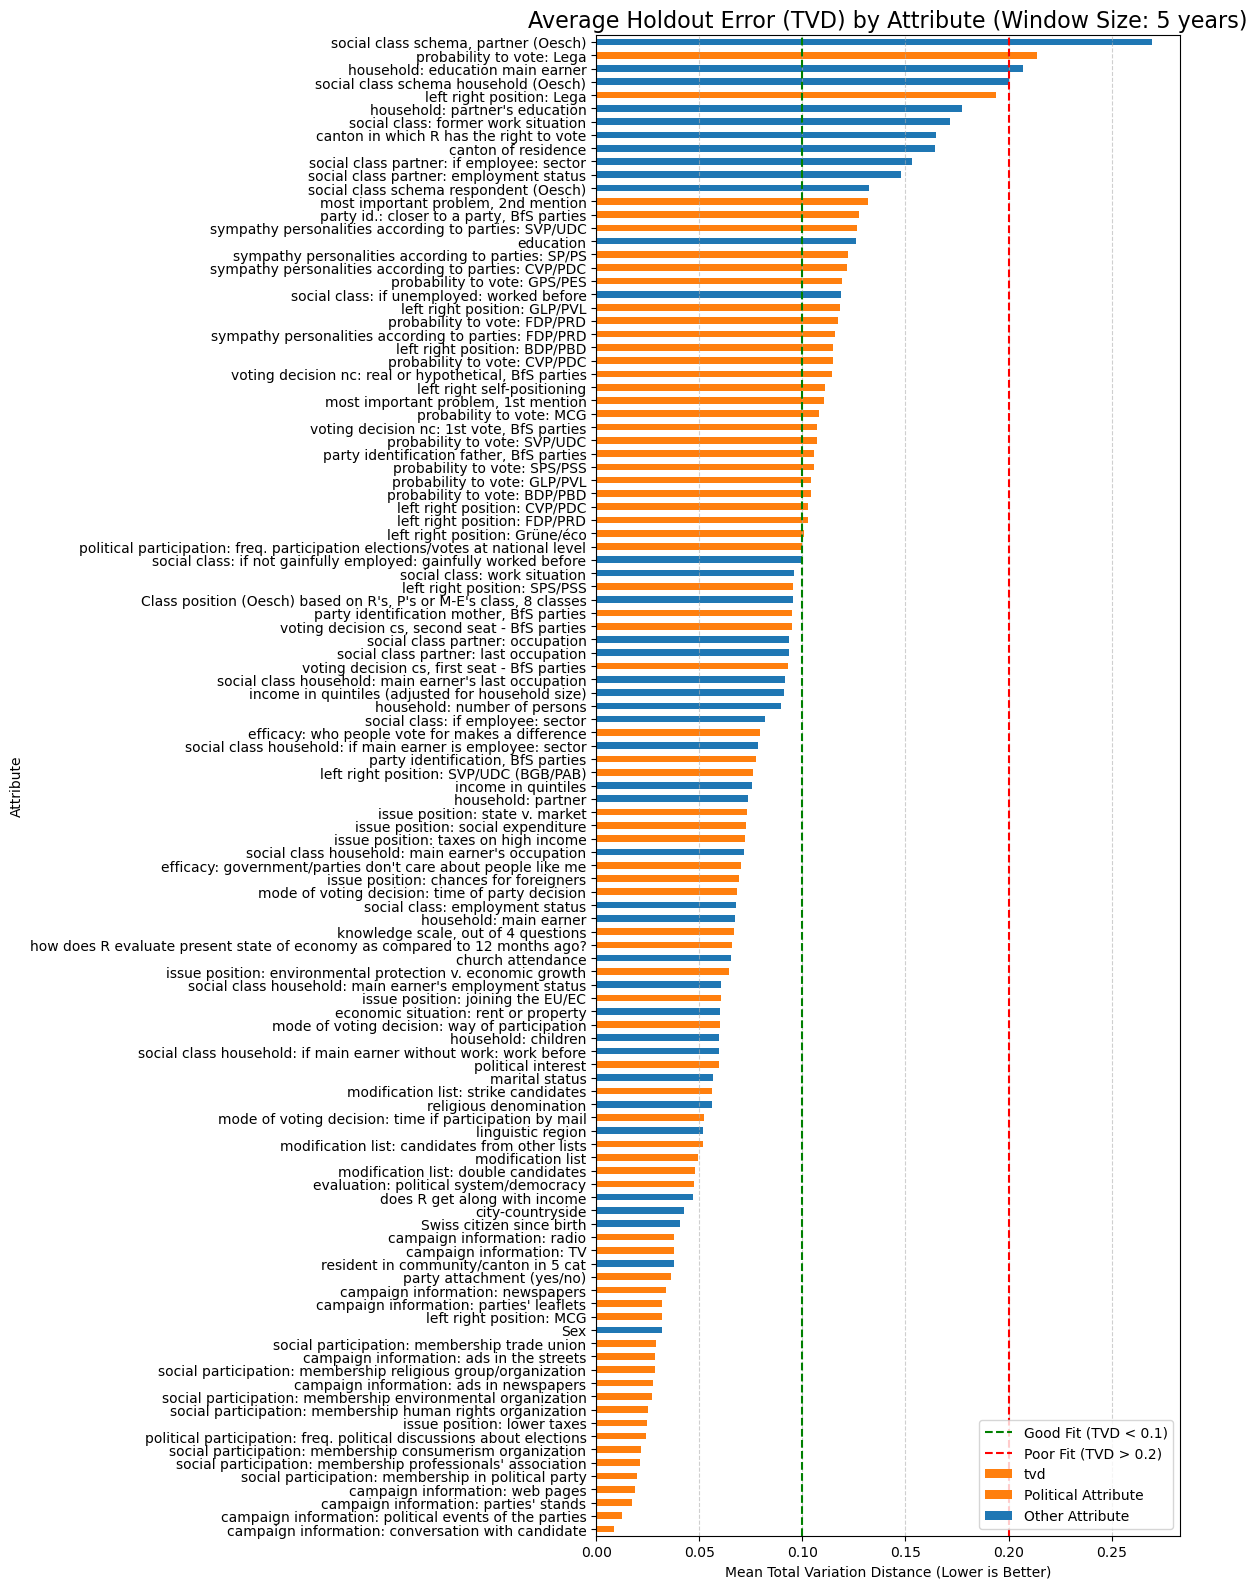

In [7]:
# --- Analysis by attribute ---
from matplotlib.patches import Patch

mean_tvd_by_attribute = results_df.groupby(results_df['attribute'].map(str))['tvd'].mean().sort_values()
colors = [POLITICAL_COLOR if attr in SELECTS_POLITICAL_COLUMNS else OTHER_COLOR for attr in mean_tvd_by_attribute.index]
mean_tvd_by_attribute.rename(SELECT_COLUMN_NAMES, inplace=True)

fig, ax = plt.subplots(figsize=(12, 16))
mean_tvd_by_attribute.plot(kind='barh', ax=ax, color=colors)
ax.axvline(0.1, color='green', linestyle='--', label='Good Fit (TVD < 0.1)')
ax.axvline(0.2, color='red', linestyle='--', label='Poor Fit (TVD > 0.2)')
ax.set_title(f'Average Holdout Error (TVD) by Attribute (Window Size: {1 + 2 * HOLDOUT_RADIUS_YEARS} years)',
             fontsize=16)
ax.set_xlabel('Mean Total Variation Distance (Lower is Better)')
ax.set_ylabel('Attribute')
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Create a custom legend for the colors
handles, labels = ax.get_legend_handles_labels()
handles.extend([
    Patch(facecolor=POLITICAL_COLOR, label='Political Attribute'),
    Patch(facecolor=OTHER_COLOR, label='Other Attribute')
])
ax.legend(handles=handles)

plt.tight_layout()
plt.show()

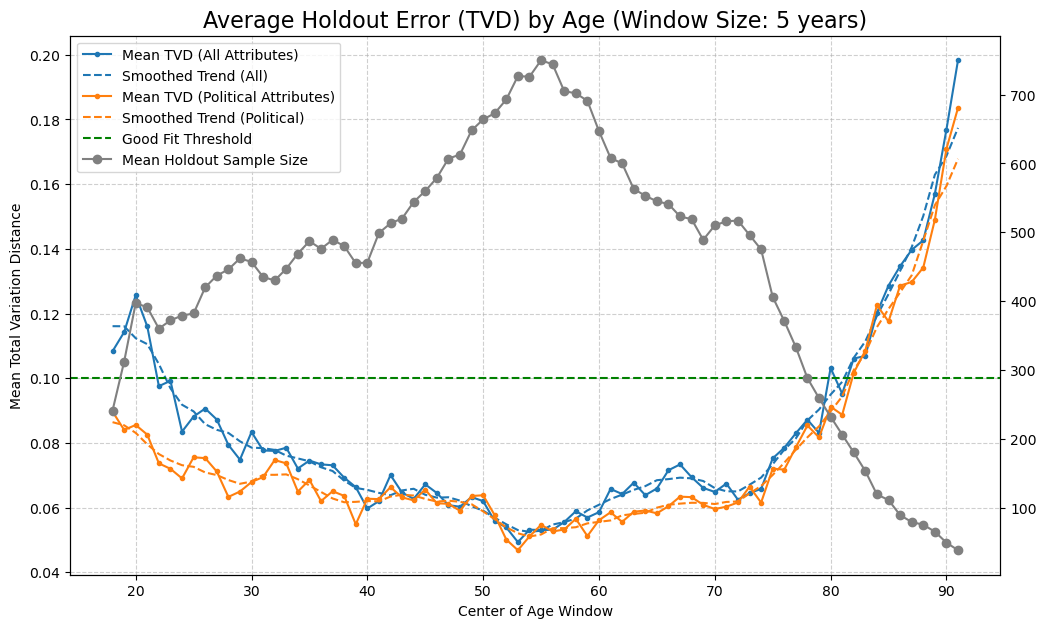

In [8]:
# --- Analysis by Age ---

# Calculate mean TVD
mean_holdout_samples = results_df.groupby('age_center')['holdout_count'].mean()
mean_tvd_by_age_all = results_df.groupby('age_center')['tvd'].mean()
mean_tvd_by_age_political = results_df[results_df['attribute'].isin(SELECTS_POLITICAL_COLUMNS)] \
    .groupby('age_center')['tvd'].mean()

fig, ax = plt.subplots(figsize=(12, 7))

# Plot mean holdout sample size on secondary axis
ax2 = ax.twinx()
mean_holdout_samples.plot(kind='line', marker='o', color='gray', ax=ax2, label='Mean Holdout Sample Size')

# Plot the main line for all attributes
mean_tvd_by_age_all.plot(kind='line', marker='.', ax=ax, label='Mean TVD (All Attributes)', color=OTHER_COLOR)
mean_tvd_by_age_all.rolling(window=5, center=True, min_periods=1).mean().plot(
    kind='line', color=OTHER_COLOR, linestyle='--', ax=ax, label='Smoothed Trend (All)'
)

# Plot the second line for political attributes
mean_tvd_by_age_political.plot(kind='line', marker='.', ax=ax, label='Mean TVD (Political Attributes)',
                               color=POLITICAL_COLOR)
mean_tvd_by_age_political.rolling(window=5, center=True, min_periods=1).mean().plot(
    kind='line', color=POLITICAL_COLOR, linestyle='--', ax=ax, label='Smoothed Trend (Political)'
)

ax.axhline(0.1, color='green', linestyle='--', label='Good Fit Threshold')
ax.set_title(f'Average Holdout Error (TVD) by Age (Window Size: {1 + 2 * HOLDOUT_RADIUS_YEARS} years)', fontsize=16)
ax.set_xlabel('Center of Age Window')
ax.set_ylabel('Mean Total Variation Distance')
ax.grid(linestyle='--', alpha=0.6)
ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
          ax.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1],
          loc='upper left')
plt.show()